<a href="https://colab.research.google.com/github/lucas-pinto/NUIN443/blob/main/problemSets/NUIN443_ps2_SystId.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PROBLEM SET 2: SYSTEMS IDENTIFICATION #

Here we will review some of the key concepts from the systems identification class. <br>
We will first generate some toy data to illustrate the autocorrelation properties of linear filters. <br>
We will then estimate simple and complex receptive fileds with STA/STC. Have fun! <br>

In [84]:
# PROBLEM SET INTRO AND SETUP
import numpy as np
import matplotlib.pyplot as plt
import pickle

%matplotlib widget
%matplotlib widget


In [85]:
# LOAD DATA
#!wget -nc https://www.dropbox.com/scl/fi/8iyw7zhlkgea3qvzz02nh/nuin443_white_noise_data.pickle?rlkey=k71fay0r4ou8li64o0jqpfe42&dl=0

## Problem 1: Linear systems and autocorrelation ##

**1a**. Generate input \\(x\\) as 100 seconds of white noise with 10-ms steps. Generate 1 second of the following filter: \\(h(\tau)=e^{-\tau/x}\\). Finally, generate the response \\(y\\) by convolving \\(x\\) and \\(h\\). Plot \\(x\\), \\(h\\) and \\(y\\)  <br>
**1b**. Now compute the autocorrelation function of \\(x\\) and the cross-correlation function between \\(x\\) and \\(y\\), and plot the first second of both around the peak. How does the cross-correlation compare to \\(h\\)? Why? <br>

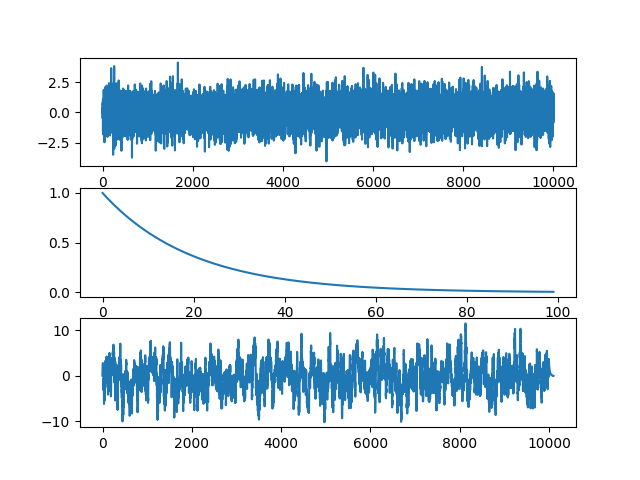

In [86]:
# 1a. Generate and plot x, h, and y
# 1a. Generate and plot x, h, and y
X = np.random.normal(0,1,(10000))
tau=0.2
h = np.exp((np.linspace(0,1,100)*-1)/tau)
y = np.convolve(X, h)

fig, ax = plt.subplots(nrows=3)
ax[0].plot(X)
ax[1].plot(h)
ax[2].plot(y)


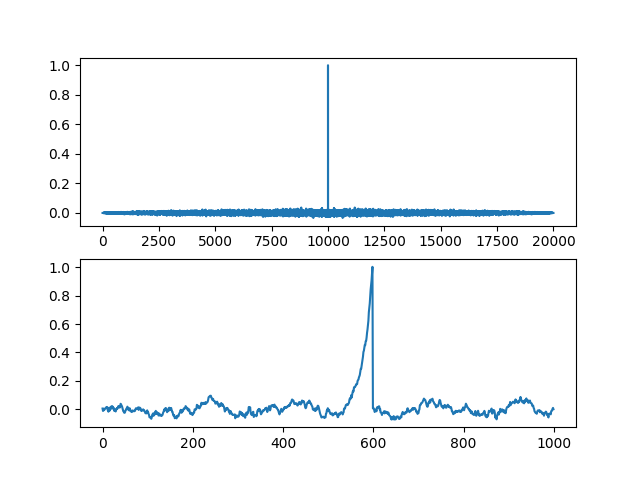

In [96]:
# 1b. Compute and the autocorrelation of x and the cross-correlation between x and y
auto = np.correlate(X,X, mode='full') / X.shape[0]
fig2, ax2 = plt.subplots(nrows=2)
ax2[0].plot(auto)

cross = np.correlate(X,y, mode='full') / X.shape[0]
ax2[1].plot(cross[9500:10500])



In [88]:
# 1b. How does the cross-correlation compare to h? Why? (answer as a comment)

##cross correlation looks like the inverse of the filter

## Problem 2: STA ##

I have simulated a simple and a complex V1 receptive fields (RFs) following standard methods (e.g., as described in Schwartz et al. 2006, J Vis, 6:484-507). The key thing to know here is that simple cells are linear and complex cells are not. Specifically, our simple cell has one linear componenent and the complex cell, two non-linear (quadratic) components that get added to produce a response. After the filter output is calculated, we pass it through a Poisson non-linearity to generate spikes. <br> <br>
The spikes were generated by multiplying the spatial kernels of each cell with a sequence of 50,000 white-noise stimuli. You will be given this stimulus sequence and a vector of spike counts for each cell. First, we'll do the easy thing and estimate the simple cell's RF with STA.

**2a**. Load the data and read a description of the variables. <br>
**2b**. Plot a few frames of the white-noise stimuli to get a sense for what they look like. Note that, unlike the class example, we're using sparse-ish binary noise. Over frames, this still converges to white-noise statistics, but has the advantage of driving neurons more strongly because of higher local image contrast. <br>
**2c**. Compute the STA for the simple cell. Plot the results side by side with the ground-truth RF. <br>

In [89]:
# 2a. Load data
filename    = '../data/nuin443_white_noise_data.pickle?rlkey=k71fay0r4ou8li64o0jqpfe42'
with open(filename, 'rb') as handle:
    [spike_data, stim_data, rf_groundtruth] = pickle.load(handle)

# Explanation of the data:
# spike_data contains simulated spike count data for a simple and a complex cell in sec (in 10-ms bins)
# spike_data['spike_ts_sec'] : time stamps corresponding to each spike count bin
# spike_data['spike_counts_simpleCell']  : spike counts for the simple cell
# spike_data['spike_counts_complexCell'] : spike counts for the complex cell

# stim_data contains information about the white-noise stimuli
# stim_data['stim_ts_sec'] : time stamp for each stimulus frame in sec (in 100-ms bins)
# stim_data['stim_sequence'] : the sequence of 50,000 white noise frames in boolean format, needs to be converted to float

# rf_groundtruth contains the spatial receptive fields used to generate the data, for you to compare your estimates to
# rf_groundtruth['simple_spatialKernel']  : 8 x 8 matrix of the receptive field
# rf_groundtruth['complex_spatialKernel'] : 8 x 8 x 2, where the 3rd dimension corresponds to the subcomponents used to generate spiking data. They were squared and then summed

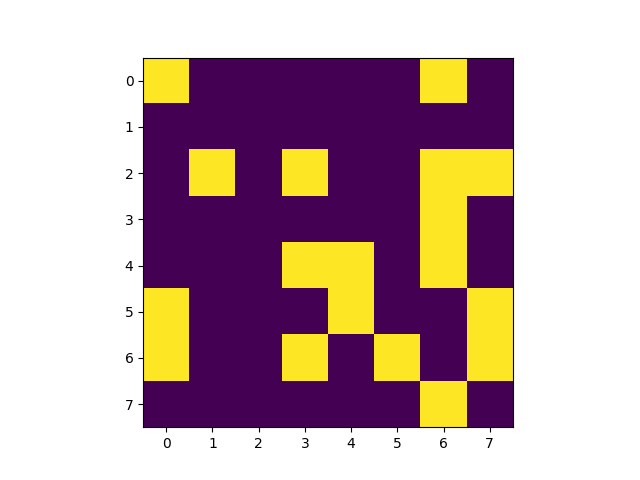

In [90]:
# 2b. Plot a few frames of the white-noise stimuli to get a sense for what they look like.

#fig, ax = plt.subplots()
stim= stim_data['stim_sequence'].astype('float')
stim_ts = stim_data['stim_ts_sec']
spikes = spike_data['spike_counts_simpleCell']
spikes_ts = spike_data['spike_ts_sec']


fig, ax = plt.subplots()
plt.imshow(stim[:,:,2])

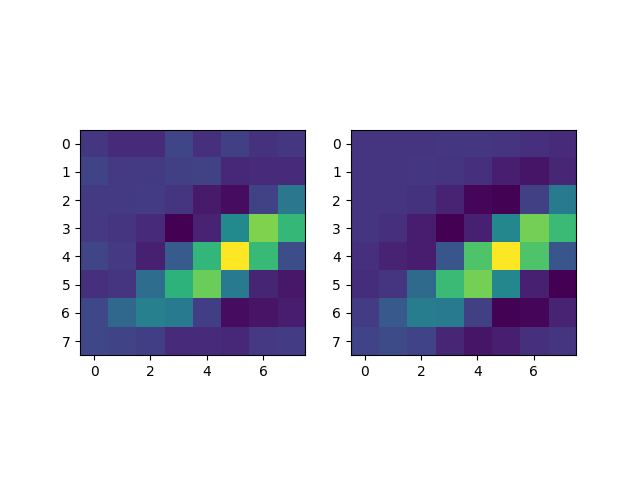

In [91]:
# 2c. Compute the STA for the simple cell. Plot the results side by side with the ground truth RF
# Remember to scale the triggered images by the spike counts
# Also note that, in reality, you would compute the STA for multiple time lags w.r.t. the spike, since
# you don't a priori know the latency, temporal kernel etc. Here, for simplicity you can assume that
# all relevant spikes happen within the 100 ms of each stimulus frame
spikes_per_stim = []
for stim_t in stim_ts:
    spikes_per_stim.append(np.sum(spikes[np.logical_and(spikes_ts > stim_t, spikes_ts < stim_t+.1)]))
spikes_per_stim = np.array(spikes_per_stim)
stim_reshape =stim.reshape(stim.shape[0]*stim.shape[1], stim.shape[2])

STA = []
for idx in range(len(spikes_per_stim)):
    STA.append(spikes_per_stim[idx] * stim_reshape[:,idx])
STA = np.mean(STA, axis=0)

    

fig, ax = plt.subplots(ncols=2) 
ax[0].imshow(STA.reshape(8,8))
ax[1].imshow(rf_groundtruth['simple_spatialKernel'])

### Problem 3: STC ##

**3a**. Compute the STC matrix for the complex cell. <br>
**3b**. Do the eigendecomposition of the STC matrix and plot the ordered eigenvalues. <br>
**3c**. Now plot the two top eigenvectors alongside with the two components of the complex RF.

In [92]:
# 3a. Compute the STC for the complex cell.
# Remember that you need to subtract the STA, so that needs to be computed first!
stim= stim_data['stim_sequence'].astype('float')
stim_ts = stim_data['stim_ts_sec']
#s_spikes = spike_data['spike_counts_simpleCell']
c_spikes = spike_data['spike_counts_complexCell']
spikes_ts = spike_data['spike_ts_sec']

spikes_per_stim = []
for stim_t in stim_ts:
    spikes_per_stim.append(np.sum(c_spikes[np.logical_and(spikes_ts > stim_t, spikes_ts < stim_t+.1)]))

    
spikes_per_stim = np.array(spikes_per_stim)
stim_reshape =stim.reshape(stim.shape[0]*stim.shape[1], stim.shape[2])

STV = []
for idx in range(len(spikes_per_stim)):
    STV.append(spikes_per_stim[idx] * stim_reshape[:,idx])
STA = np.mean(STV, axis=0)

STV = np.array(STV)
STC = 1/np.sum(c_spikes) * ((STV - STA).T @ (STV - STA))

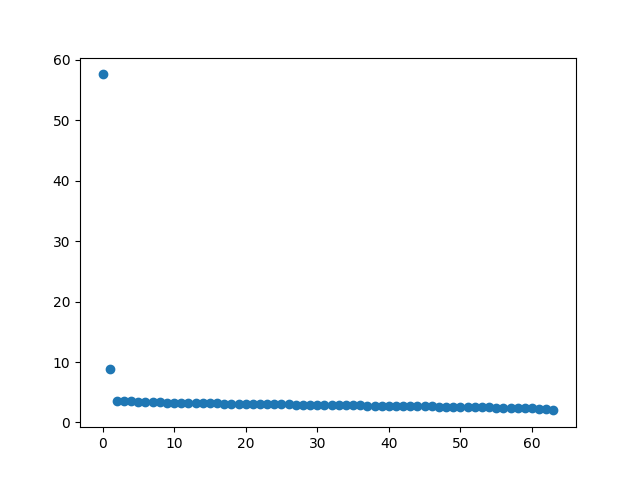

In [93]:
# 3b. Do the eigendecomposition of the STC matrix and plot the ordered eigenvalues
# (note that an ordered output is not guaranteed)
# (it's fine to use the numpy function)
evalues, evectors = np.linalg.eig(STC)
sorts = evalues.argsort()
sort_evalues = evalues[sorts[::-1]]
sort_evectors = evectors[:, sorts[::-1]]
fig2, ax2 = plt.subplots()
ax2.scatter(np.arange(len(sort_evalues)), sort_evalues)

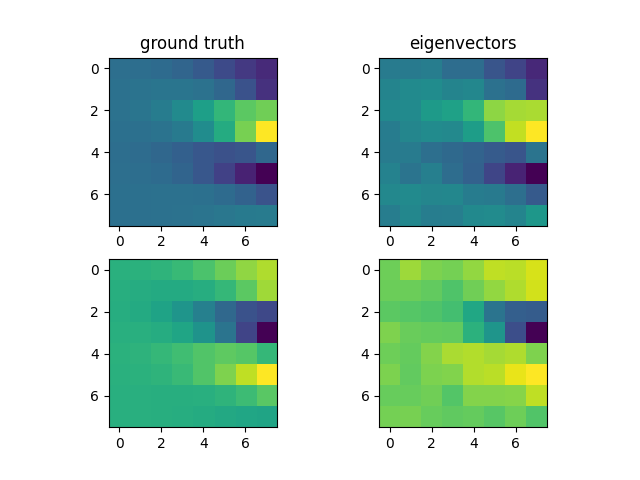

In [95]:
# 3c. Now plot the two top eigenvectors alongside with the two components of the complex RF
fig, ax = plt.subplots(nrows=2, ncols=2)
ax[0][0].imshow(rf_groundtruth['complex_spatialKernel'][:,:,0])
first = sort_evectors[:,1].reshape(8,8) 
ax[0][1].imshow(first)
ax[0][0].set_title('ground truth')
ax[0][1].set_title('eigenvectors')

ax[1][0].imshow(rf_groundtruth['complex_spatialKernel'][:,:,1])
second = sort_evectors[:,0].reshape(8,8) #order is flipped for some reason...
ax[1][1].imshow(second)